Notebook to post-process and plot p-class cluster results for Rosi's MPAS aquaplanet grid.

Write-out is done by mpas_pclass_cluster_write.ipynb

Grid data read from pickle, written out but mpas_pclass_plot.ipynb

James Ruppert  
9/1/2025

### Main settings

In [1]:
import numpy as np
import pickle
import xarray as xr
import zarr
import matplotlib.pyplot as plt
# from scipy.stats import ttest_ind
import seaborn as sns
from statannotations.Annotator import Annotator

In [2]:
do_process_clusters = False
do_process_clusters = True

testing = False
# testing = True

pickle_path = "/glade/campaign/univ/uokl0049/jruppert/pickle_out"
# pickle_path = "../../../pickle_out/aquaplanet"

grid_pickle_file = f"{pickle_path}/grid_data.pickle"

exp_names = ["CTL","HOMO_RAD","CLIM_RAD"]
ntest = len(exp_names)
pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN', 'DSA']
pclass_names_long = ['DeepC', 'Congest', 'Shallow', 'Stratiform', 'Anvil', 'DSA']
nclass = len(pclass_names)

### Main driver loop

#### Functions

In [3]:
# Set latitude bounds
def subset_settings(isubset=0):

    nsubset = 4

    latbounds_all = [
        [0, 15.0],
        [10, 20.0],
        [15, 20.0],
    ]

    if isubset < 3:
        global_subset = True
        latbounds = latbounds_all[isubset]
    else:
        global_subset = False
        latbounds = None

    subset_tags = []
    for isubset in range(nsubset):

        if isubset < 3:
            subset_tags.append(f"({str(latbounds_all[isubset][0])}-{str(int(latbounds_all[isubset][1]))}N)")
        else:
            subset_tags.append("Global")

    return nsubset, subset_tags, latbounds, global_subset
nsubset, subset_tags, latbounds, global_subset = subset_settings()

In [4]:
# Get list of desired file times

file_times_arr = np.arange('2000-05-01T06:00:00', '2000-05-11T06:00:00', 6, dtype='datetime64[h]')
file_times = [file_times_arr[i].astype('datetime64[D]').astype(str)+'_'+str(file_times_arr[i]).split('T')[1].split(':')[0]+'.00.00' for i in range(len(file_times_arr))]
ntime = len(file_times)

In [5]:
# Masks outside target zrea by setting label = 0; doesn't change shape
def latitude_masking(labels_in, latitudes, latbounds):
    labels_filtered = labels_in.copy()
    mask_outside = np.where((latitudes < latbounds[0]) | (latitudes > latbounds[1]))[0]
    labels_filtered[mask_outside] = 0
    return labels_filtered

In [6]:
var_tags = ['area', 'mu', 'md', 'cape', 'cin']
units = ['m$^2$', 'kg/m$^2$/s', 'kg/m$^2$/s', 'J/kg', 'J/kg']
nvars = len(var_tags)

def initiate_vars_iexp():
    # Initiate dictionary to hold clusters
    cluster_vars_iexp = {}
    for ivar in var_tags:
        cluster_vars_iexp[ivar] = {}
        for isubset in range(nsubset):
            cluster_vars_iexp[ivar][isubset] = {}
            for iclass_name in pclass_names_long:
                cluster_vars_iexp[ivar][isubset][iclass_name] = []
    return cluster_vars_iexp

#### Loop to process/read data

In [7]:
# %%time

pickle_path_output = "/glade/derecho/scratch/ruppert/tc-crfrad/mpas"

# Grid info

with open(grid_pickle_file, 'rb') as f:
    areaCell, latCell, lonCell = pickle.load(f)
ncell = areaCell.shape[0]

# Read pickled cluster data, compute statistics

cluster_vars = {}

# for expName in exp_names:
for expName in exp_names[1:]:
# for expName in exp_names[0:1]:

    pickle_file_iexp = f"{pickle_path}/pclass_cluster_{expName}.pickle"

    if do_process_clusters:

        cluster_vars_iexp = initiate_vars_iexp()

        for time in file_times:

            rawvars = np.zeros((nvars, ncell))

            # Read VMF
            vmf_files = f"{pickle_path_output}/{expName}/vmfs.{time}.nc"
            ds_vmf = xr.open_dataset(vmf_files)
                        # combine="nested", concat_dim="Time",
                        # parallel=True,
                        # chunks={"Time": -1, "nCells": nCells_chunk_size})
            rawvars[1,:] = ds_vmf.mu[0]
            rawvars[2,:] = ds_vmf.md[0]

            # Read CAPE
            cape_path = f"{pickle_path_output}/{expName}/CAPE_{time}.zarr"
            root = zarr.open(cape_path, mode="r")
            rawvars[3,:] = root["CAPE"][:]
            rawvars[4,:] = root["CIN"][:]

            # Read cluster labels from pickle
            pickle_file_in = f"{pickle_path_output}/{expName}/pclass_cluster_{expName}_{time}.pickle"
            with open(pickle_file_in, 'rb') as f:
                lists = pickle.load(f)

            # Object count
            # numbers[itest, it, :] = lists[1]

            for isubset in range(nsubset):

                # Get latitude bounds
                nsubset, subset_tags, latbounds, global_subset = subset_settings(isubset)

                for iclass in range(nclass):
                    labels_write = np.array(lists[0][iclass])
                    if global_subset:
                        # Mask objects that go out of selected latitude bounds
                        labels_write = latitude_masking(labels_write, latCell, latbounds)
                    # assume labels_write has the same shape as cellarea
                    unique_labels = np.unique(labels_write)
                    # ignore background/no-label/masked labels
                    unique_labels = unique_labels[unique_labels >= 1]
                    # compute cluster areas as sum(cluster cell-count, weighted by cell area)
                    cluster_area = np.bincount(labels_write, weights=areaCell)
                    # restrict to valid labels only
                    cluster_area = cluster_area[unique_labels]

                    # Average dependent variables over clusters
                    for ivartag in range(nvars):
                        # Just area
                        if ivartag == 0:
                            ivar = 1
                            cluster_vars_iexp['area'][isubset][pclass_names_long[iclass]].append(cluster_area)
                        # Cluster-averaged variables
                        else:
                            ivar = rawvars[ivartag,:]
                            var_weighted_sum = np.bincount(labels_write, weights = (areaCell * ivar))[unique_labels]
                            cluster_vars_iexp[var_tags[ivartag]][isubset][pclass_names_long[iclass]].append(var_weighted_sum / cluster_area)

            if testing:
                break

            print(f"Finished processing {expName} {time}")

        if testing:
            break

        # Convert cluster lists to arrays
        # for isubset in range(nsubset):
        #     for iclass in range(nclass):
        #         for ivartag in range(nvars):
        #             cluster_vars[var_tags[ivartag]][isubset][expName][pclass_names_long[iclass]] = \
        #                 np.array(cluster_vars[var_tags[ivartag]][isubset][expName][pclass_names_long[iclass]])

        # Write out to pickle
        if not testing:
            with open(pickle_file_iexp, 'wb') as f:
                pickle.dump([subset_tags, cluster_vars_iexp], f)

        print(f"Finished processing {expName}")

    else:

        # Read from pickle
        with open(pickle_file_iexp, 'rb') as f:
            subset_tags, cluster_vars_iexp = pickle.load(f)
        cluster_vars[expName] = cluster_vars_iexp

# Have been presenting sizes as sqrt(area), e.g.,
# mean_sizes = np.sqrt(np.mean(cluster_area)) # m^2 --> m

Finished processing HOMO_RAD 2000-05-01_06.00.00
Finished processing HOMO_RAD 2000-05-01_12.00.00
Finished processing HOMO_RAD 2000-05-01_18.00.00
Finished processing HOMO_RAD 2000-05-02_00.00.00
Finished processing HOMO_RAD 2000-05-02_06.00.00
Finished processing HOMO_RAD 2000-05-02_12.00.00
Finished processing HOMO_RAD 2000-05-02_18.00.00
Finished processing HOMO_RAD 2000-05-03_00.00.00
Finished processing HOMO_RAD 2000-05-03_06.00.00
Finished processing HOMO_RAD 2000-05-03_12.00.00
Finished processing HOMO_RAD 2000-05-03_18.00.00
Finished processing HOMO_RAD 2000-05-04_00.00.00
Finished processing HOMO_RAD 2000-05-04_06.00.00
Finished processing HOMO_RAD 2000-05-04_12.00.00
Finished processing HOMO_RAD 2000-05-04_18.00.00
Finished processing HOMO_RAD 2000-05-05_00.00.00
Finished processing HOMO_RAD 2000-05-05_06.00.00
Finished processing HOMO_RAD 2000-05-05_12.00.00
Finished processing HOMO_RAD 2000-05-05_18.00.00
Finished processing HOMO_RAD 2000-05-06_00.00.00
Finished processing 

### Binned analysis

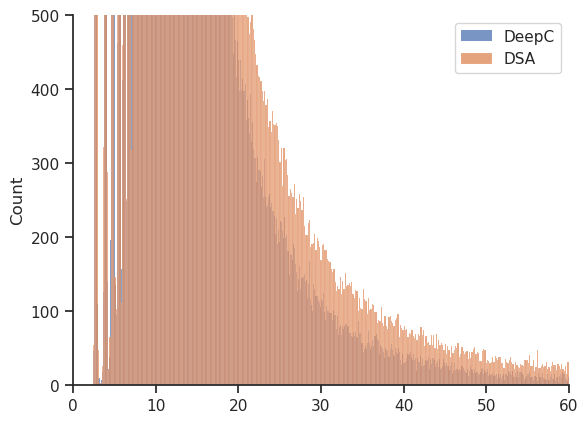

In [105]:
expName = exp_names[0]
isubset = 0

ipclass = 0

area_flat = np.concatenate(cluster_vars[expName]['area'][isubset][pclass_names_long[ipclass]])
size_flat = np.sqrt(area_flat)/1e3
sns.histplot(size_flat, label=pclass_names_long[ipclass])
plt.xlim(0,60)
plt.ylim(0,500)

ipclass = 5

area_flat = np.concatenate(cluster_vars[expName]['area'][isubset][pclass_names_long[ipclass]])
size_flat = np.sqrt(area_flat)/1e3
sns.histplot(size_flat, label=pclass_names_long[ipclass])
plt.xlim(0,60)
plt.ylim(0,500)

plt.legend()

In [128]:
def create_hexplot(x, y, z, xrange, yrange, xlabel, ylabel, zlabel, title,
                   cmap="coolwarm"):

    sns.set_theme(style="ticks", font_scale=1., rc={'xtick.bottom': True, 'ytick.left': True,
                                                    #  "axes.spines.left": False, "axes.spines.bottom": False,
                                                     "axes.spines.right": False, "axes.spines.top": False,})
    # sns.set_style("whitegrid")

    plt.figure(figsize=(7,6))
    hb = plt.hexbin(
        x, y, C=z,
        extent=(xrange[0], xrange[1], yrange[0], yrange[1]),
        gridsize=30, # number of hexes in x
        cmap=cmap,
        mincnt=50,
    )
    # sns.despine()#offset=10)
    plt.colorbar(hb, label=zlabel, shrink=0.6)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # Remove grid lines
    # plt.grid(False)
    plt.show()
    return None

In [67]:
print(pclass_names_long)
print(subset_tags)

['DeepC', 'Congest', 'Shallow', 'Stratiform', 'Anvil', 'DSA']
['(0-15N)', '(10-20N)', '(15-20N)', 'Global']


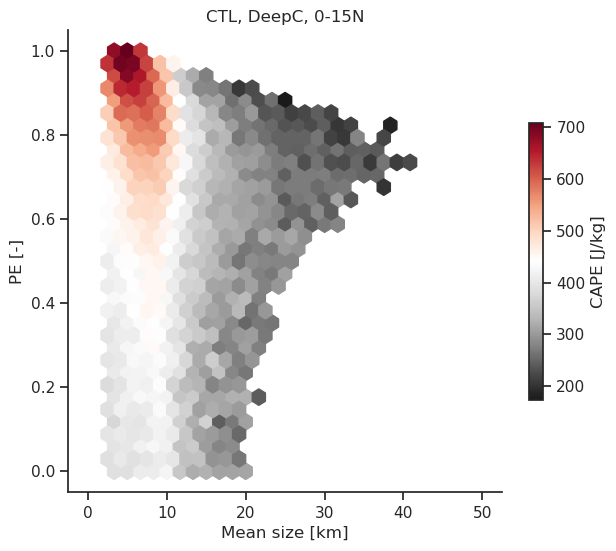

In [132]:
expName = exp_names[0]
ipclass = 0
isubset = 0

area_flat = np.concatenate(cluster_vars[expName]['area'][isubset][pclass_names_long[ipclass]])
size_flat = np.sqrt(area_flat)/1e3
mu_flat = np.concatenate(cluster_vars[expName]['mu'][isubset][pclass_names_long[ipclass]])
md_flat = np.concatenate(cluster_vars[expName]['md'][isubset][pclass_names_long[ipclass]])
pe_flat = (1 - (-md_flat)/mu_flat)
cape_flat = np.concatenate(cluster_vars[expName]['cape'][isubset][pclass_names_long[ipclass]])
cin_flat = np.concatenate(cluster_vars[expName]['cin'][isubset][pclass_names_long[ipclass]])

x = size_flat
y = pe_flat
z = cape_flat

x_range = (0, 50)
y_range = (0, 1)

xlabel = "Mean size [km]"
ylabel = "PE [-]"
zlabel = "CAPE [J/kg]"
title = f"{expName}, {pclass_names_long[ipclass]}, {subset_tags[isubset][1:-1]}"

create_hexplot(x, y, z, x_range, y_range, xlabel, ylabel, zlabel, title,
               cmap="RdGy_r")

### Plotting

#### Test latitude masking and plotting of clusters

In [17]:
# # Test latitude masking and plotting of clusters

# # Read pickles
# figname = f"test_clusters_{exp_names[0]}_it20.png"
# pickle_file_in = f"{pickle_path_read}/{exp_names[0]}/pclass_cluster_{exp_names[0]}_{file_times[20]}.pickle"
# with open(pickle_file_in, 'rb') as f:
#     lists = pickle.load(f)

# grid_path = "/glade/work/rberrios/MPAS/aqua_sstmax10N_ASD/plus4K/TC_3km/x5.tropical_3km_10N.init.nc"
# grid = xr.open_dataset(grid_path)
# # areaCell = grid.areaCell
# latCell = np.degrees(grid.latCell)
# lonCell = np.degrees(grid.lonCell)

# iclass=0
# labels_write = lists[0][iclass]
# # # Mask objects that go out of selected latitude bounds
# # # labels_filtered, indices_inside = latitude_masking(labels_write, latCell, latbounds)
# # # assume labels_write has the same shape as cellarea
# # unique_labels = np.unique(labels_filtered)
# # # ignore background/no-label
# # unique_labels = unique_labels[unique_labels >= 1]
# # # compute weighted cluster size
# # cluster_area = np.bincount(labels_filtered, weights=areaCell[indices_inside])
# # # restrict to valid labels only
# # cluster_area = cluster_area[unique_labels]

# labels_masked = np.ma.masked_where(labels_write == 0, labels_write)
# fig = plt.figure(figsize=(12,10))
# fig.set_facecolor('white')
# ax = fig.add_subplot(211)#, aspect='equal')
# sc = ax.scatter(lonCell, latCell, c=labels_masked, cmap="tab20", s=2, marker="s")
# # ax.set_title("Clusters (N = "+str(nfeat)+")")
# # ax.set_xlabel('[km]')
# # ax.set_ylabel('[km]')
# # latbounds = [-5, 20.0]
# # ind_within_lat = np.where( (latCell >= latbounds[0]) & (latCell <= latbounds[1]) )[0]
# # plt.ylim((np.min(latCell[ind_within_lat]), np.max(latCell[ind_within_lat])))
# plt.ylim([-5,20])
# # plt.tight_layout()
# plt.show()
# plt.savefig(figname, dpi=200)
# # plt.text(500,1750, 'Total = '+str(num_features))
# # return None

#### Binned CAPE analysis

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(6,5))
hb = plt.hexbin(x, y, C=z, gridsize=40, reduce_C_function=np.mean, cmap="coolwarm")
plt.colorbar(hb, label='Avg Z')
sns.despine()
plt.show()

#### Box plots

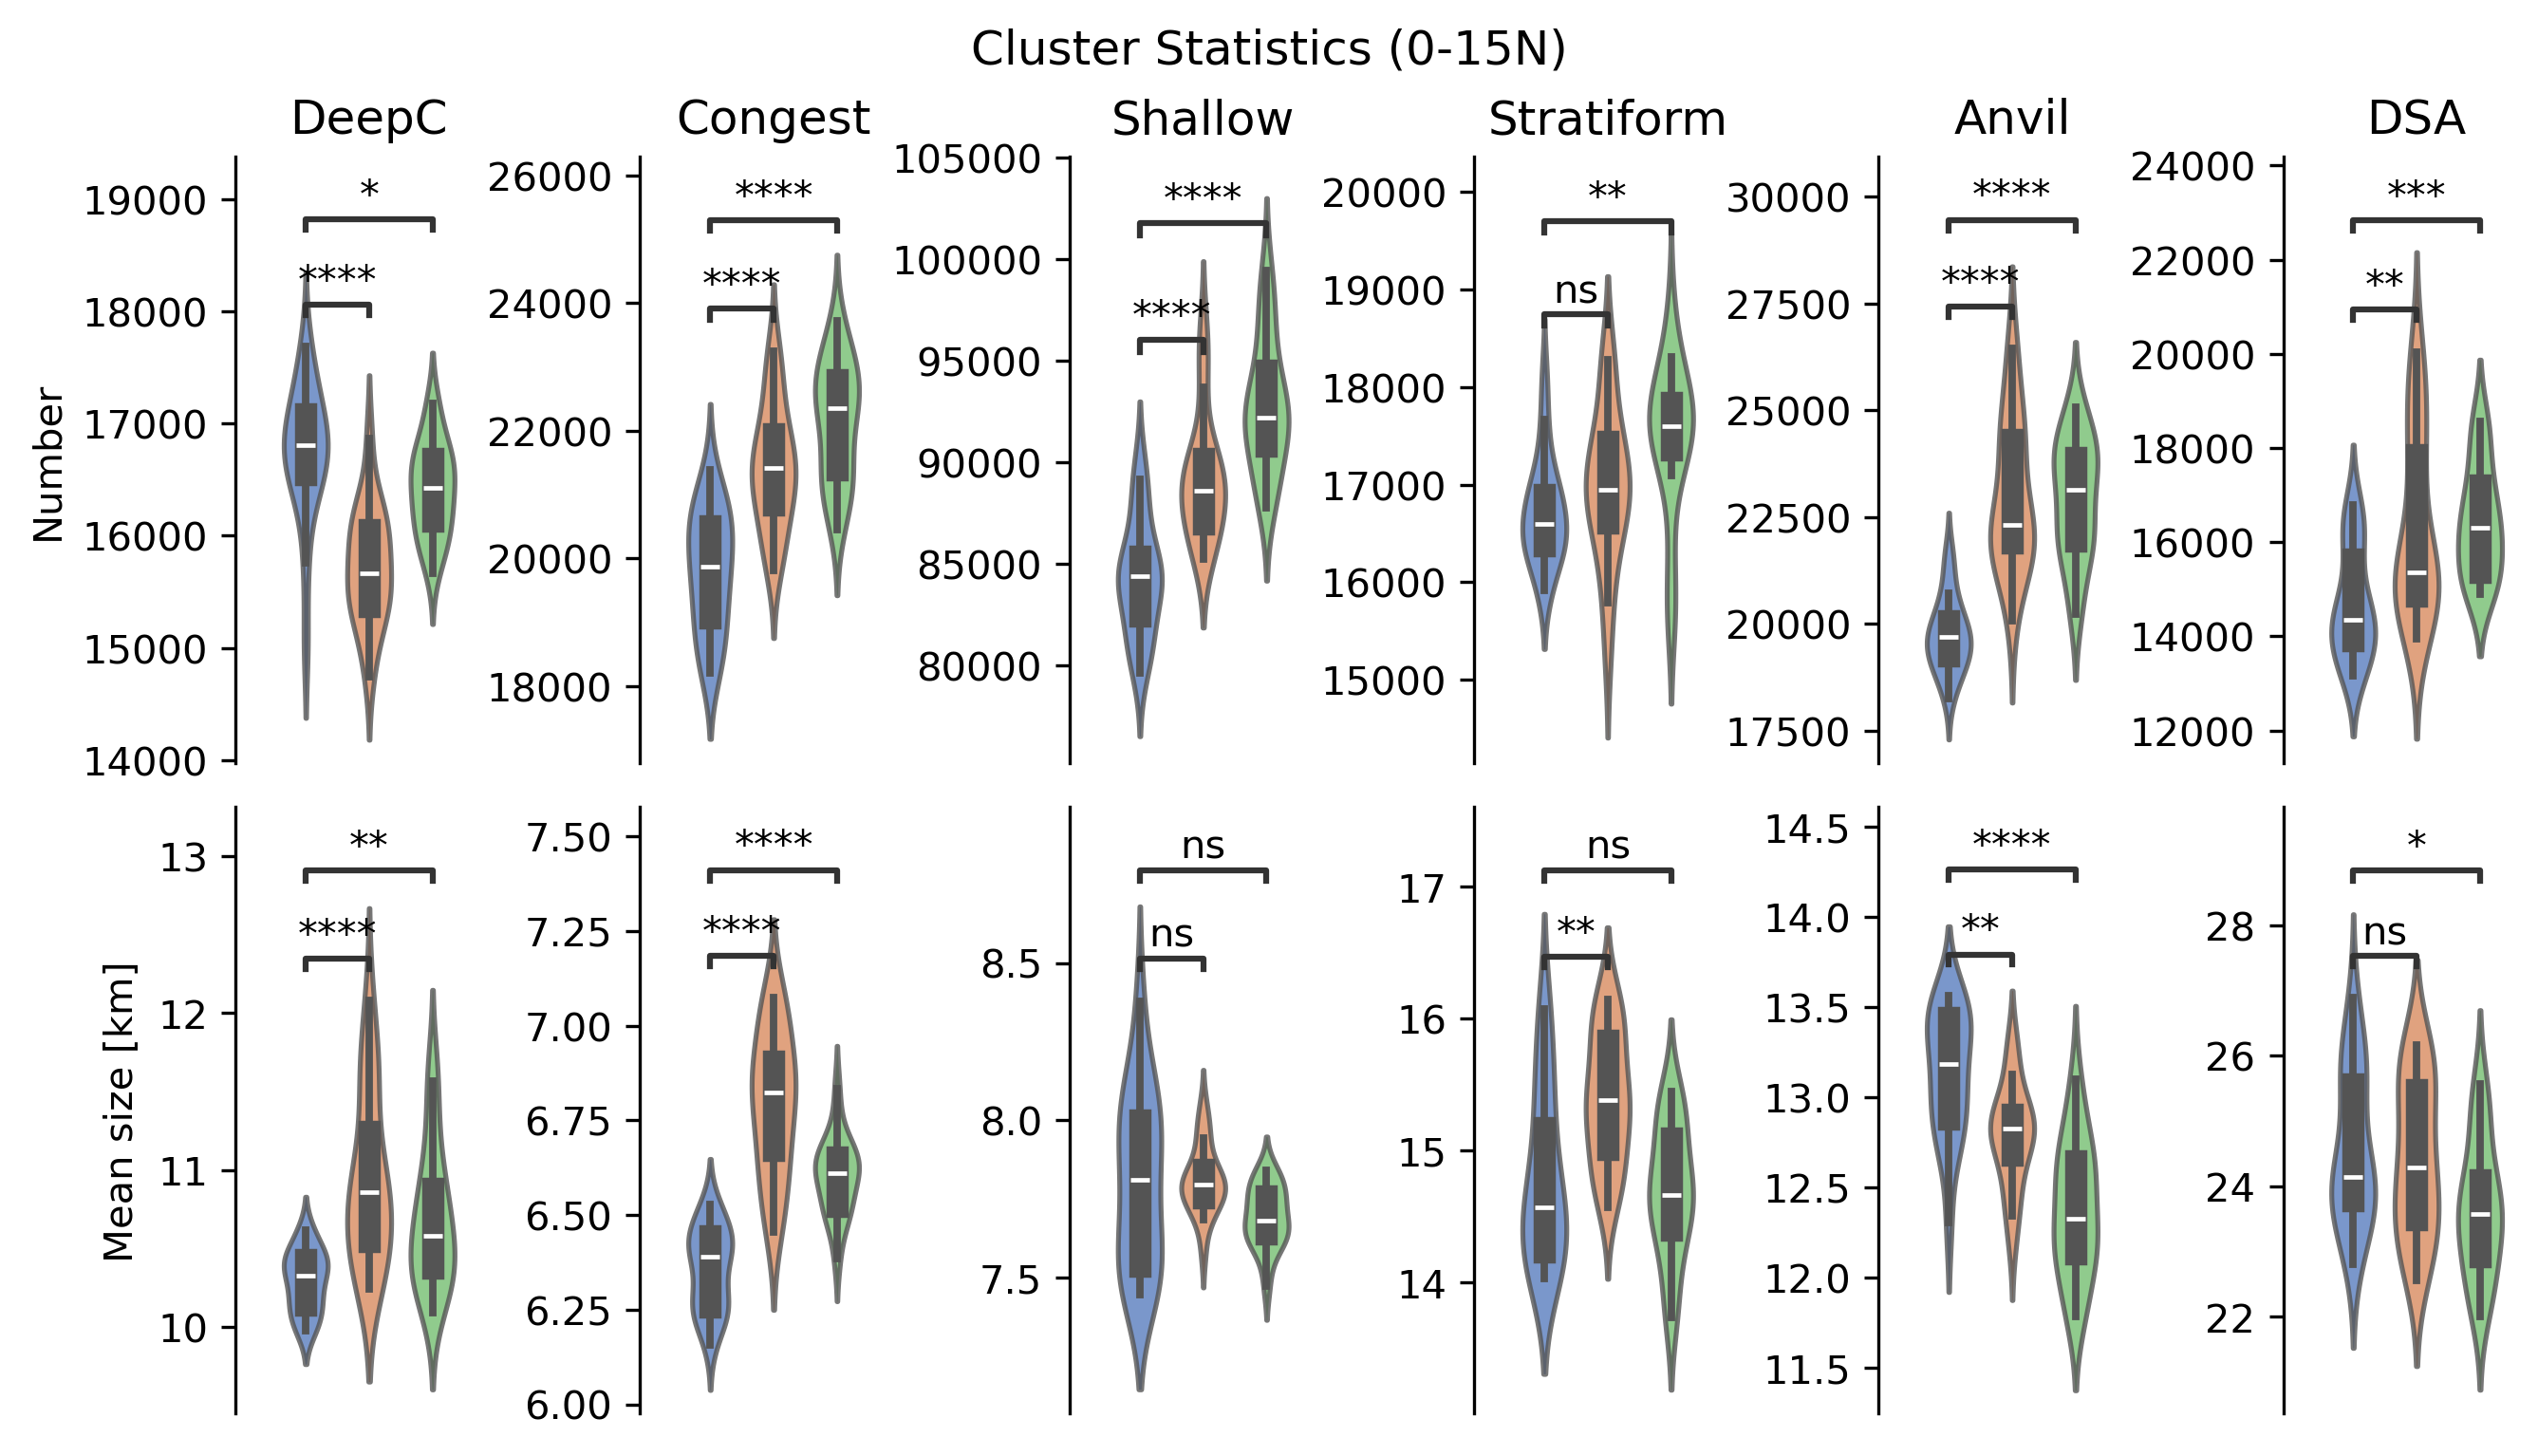

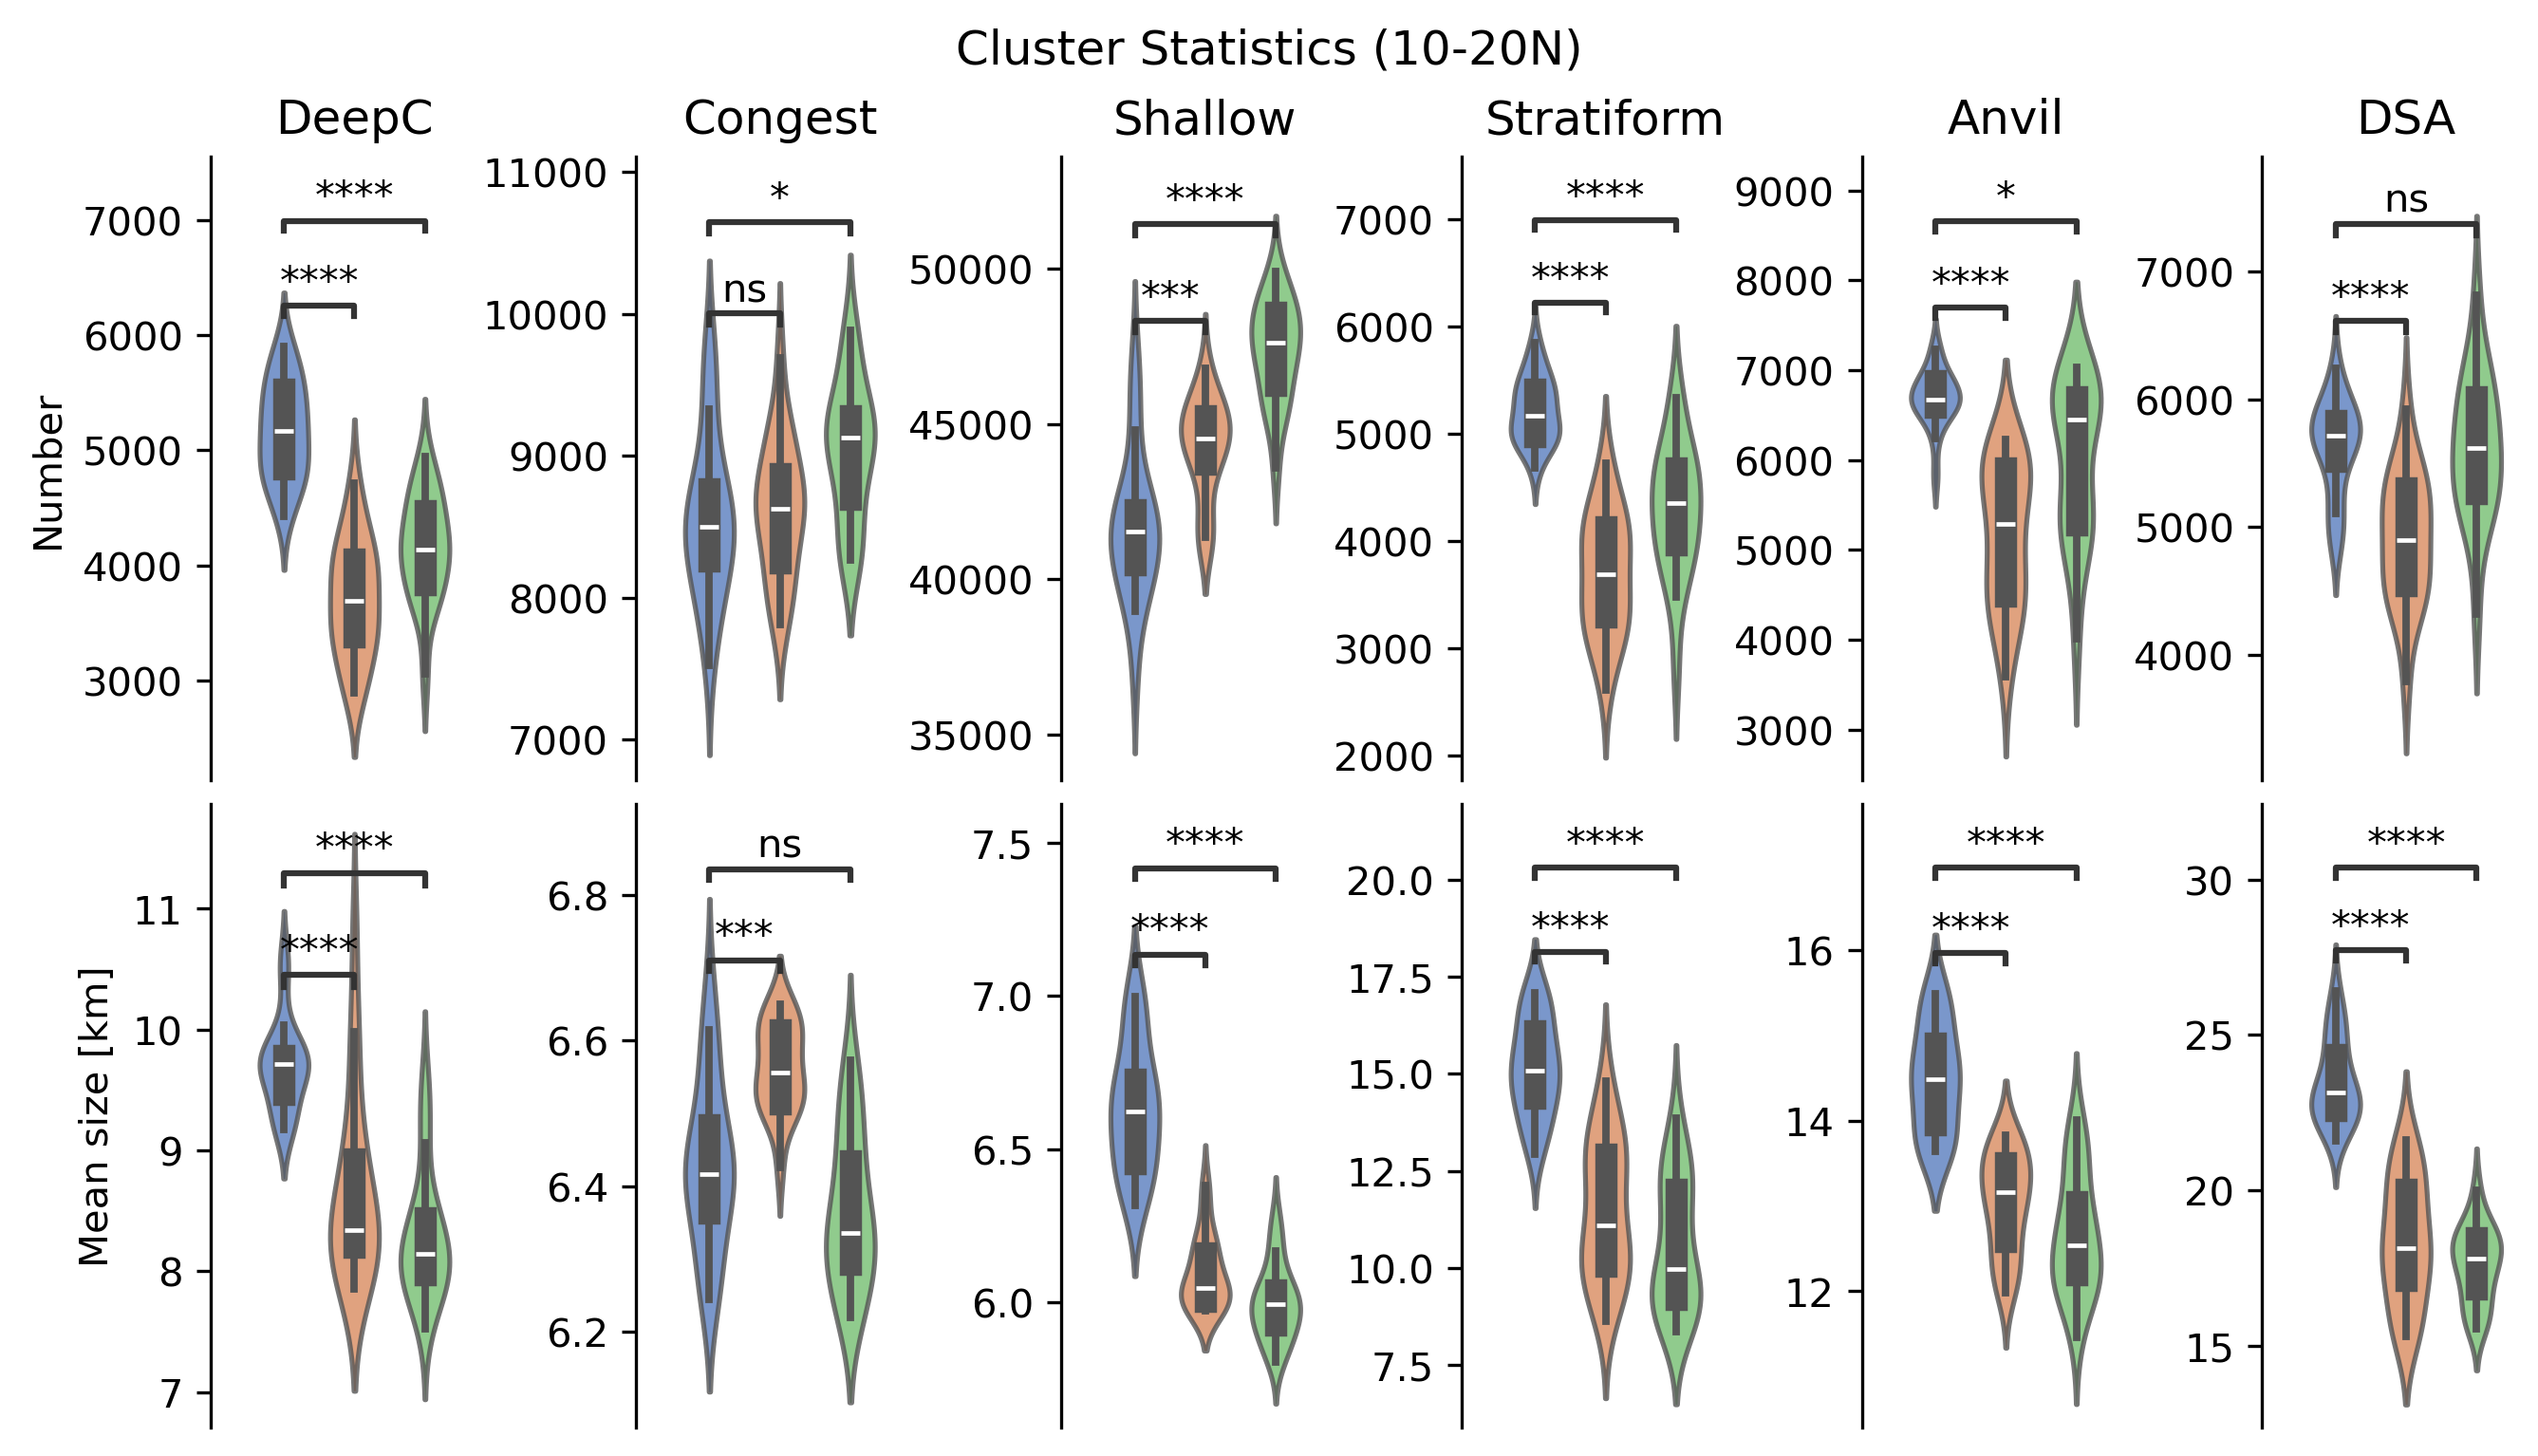

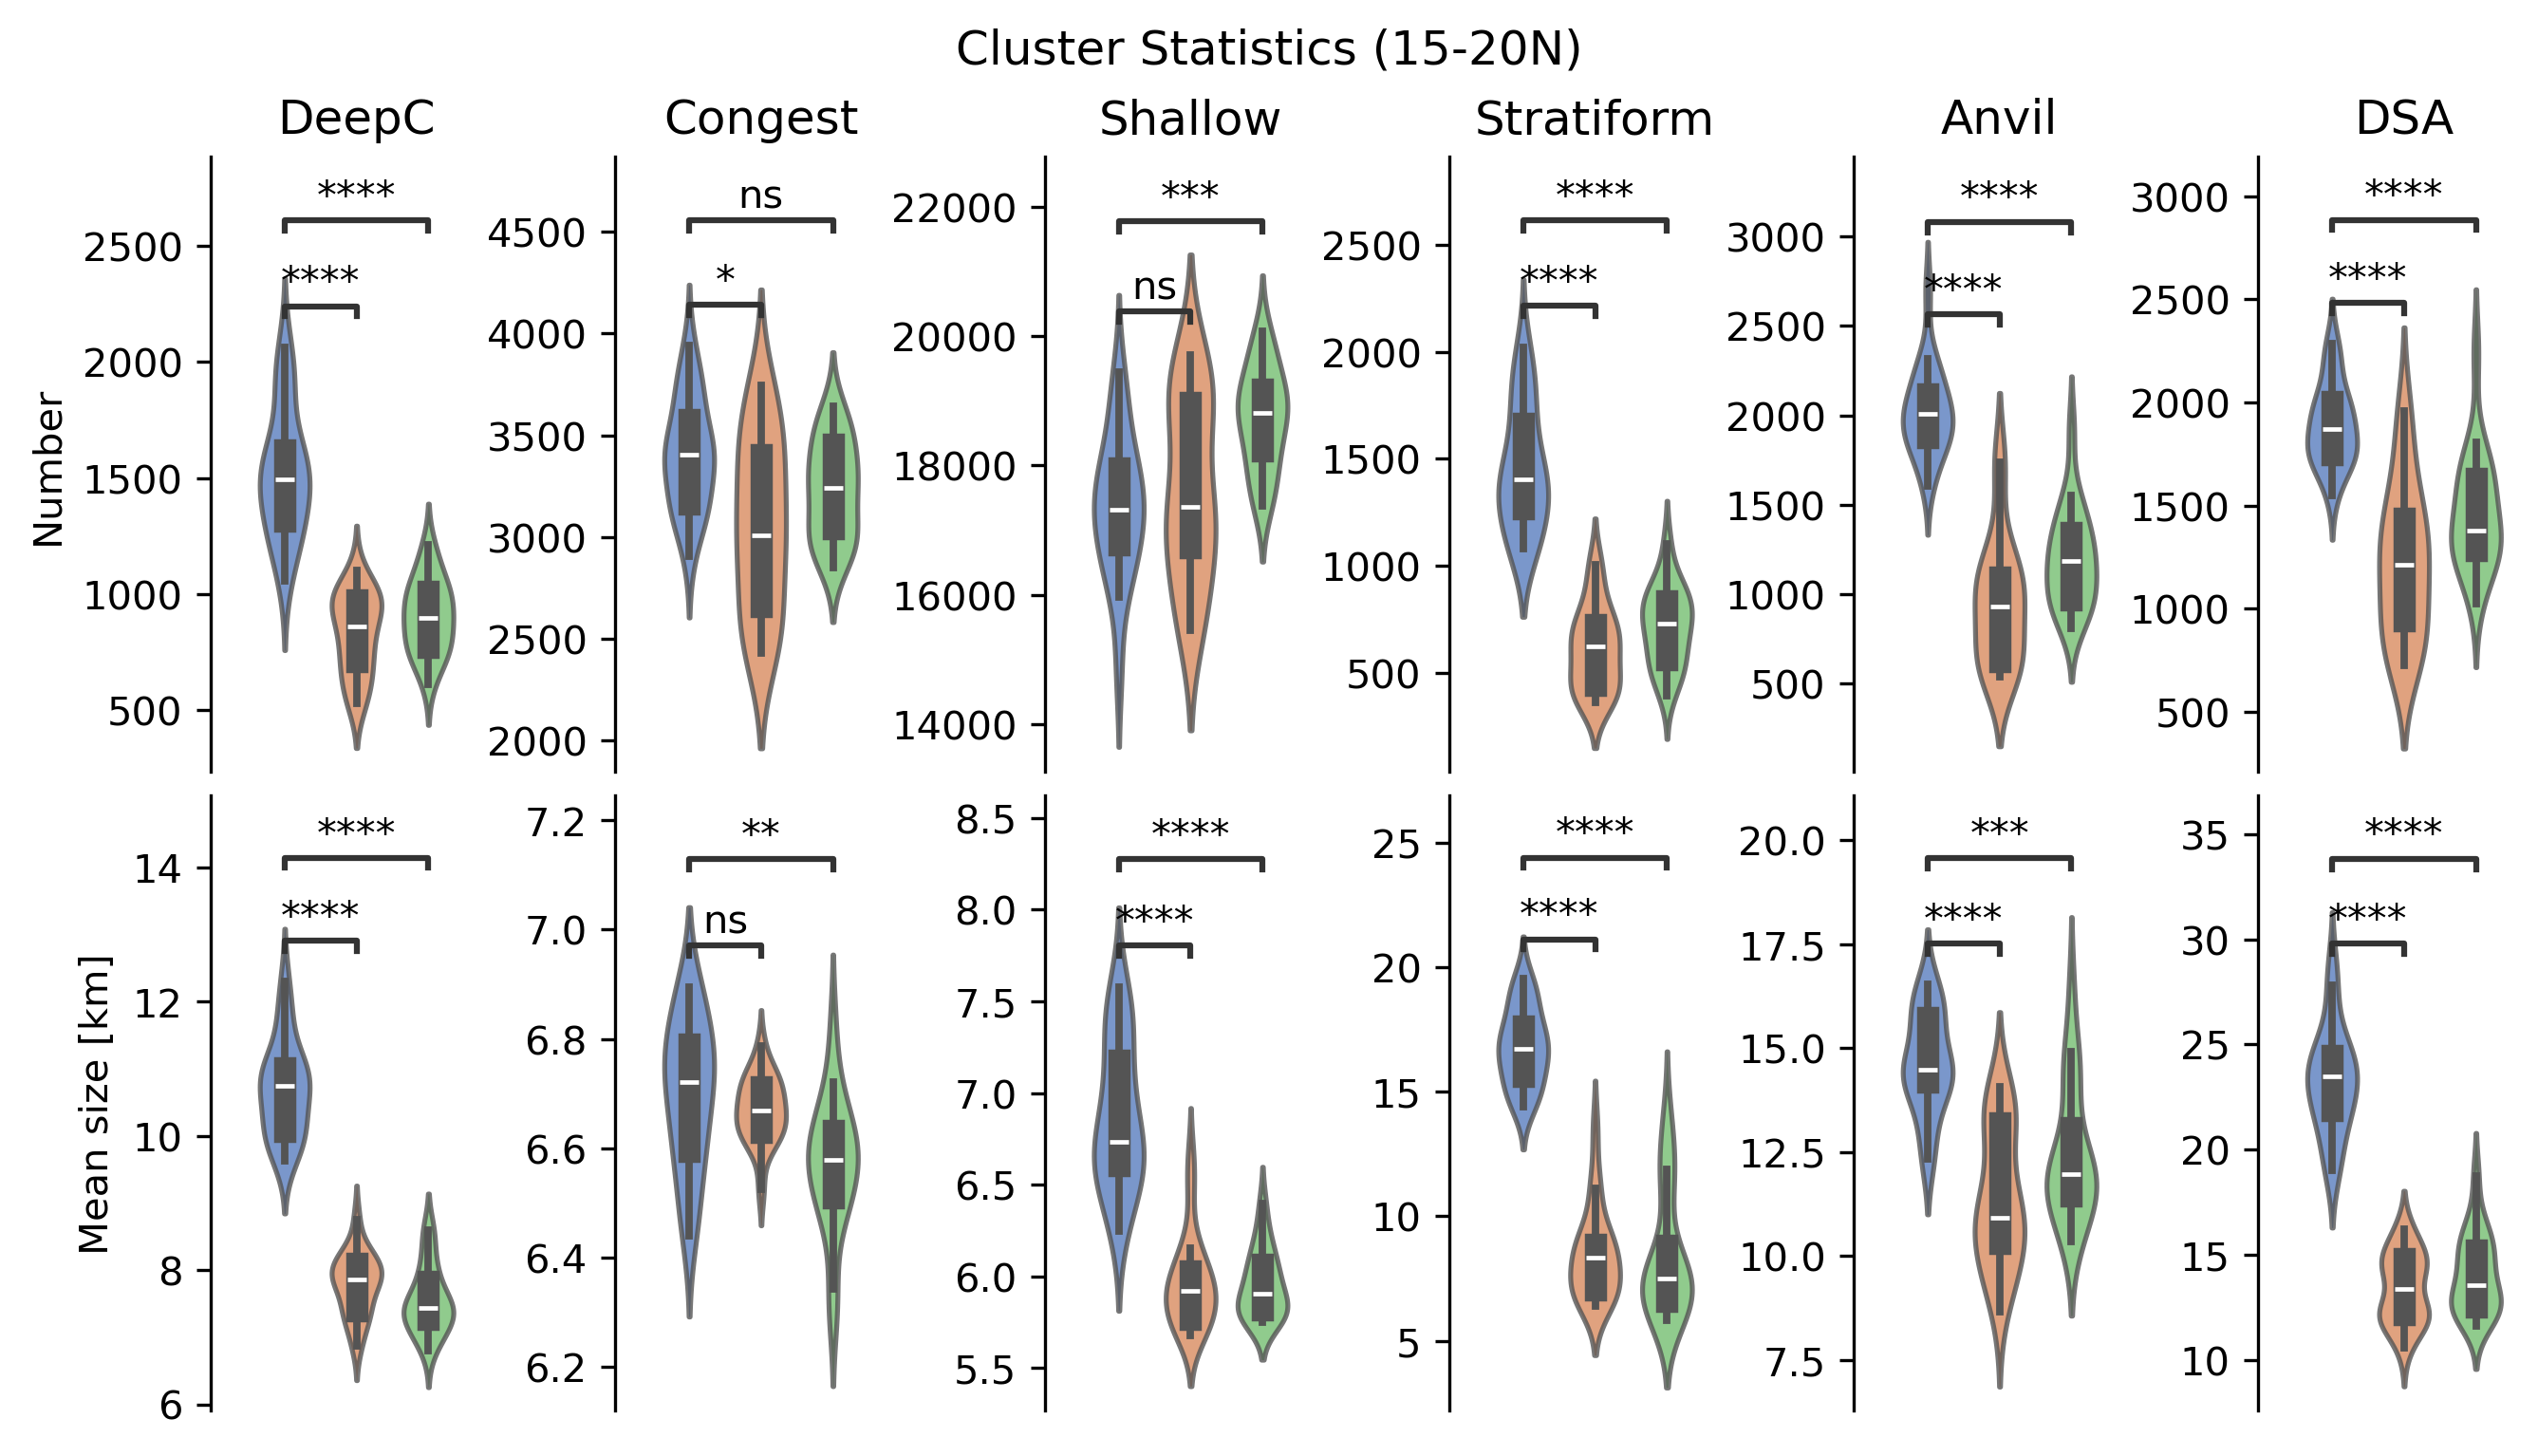

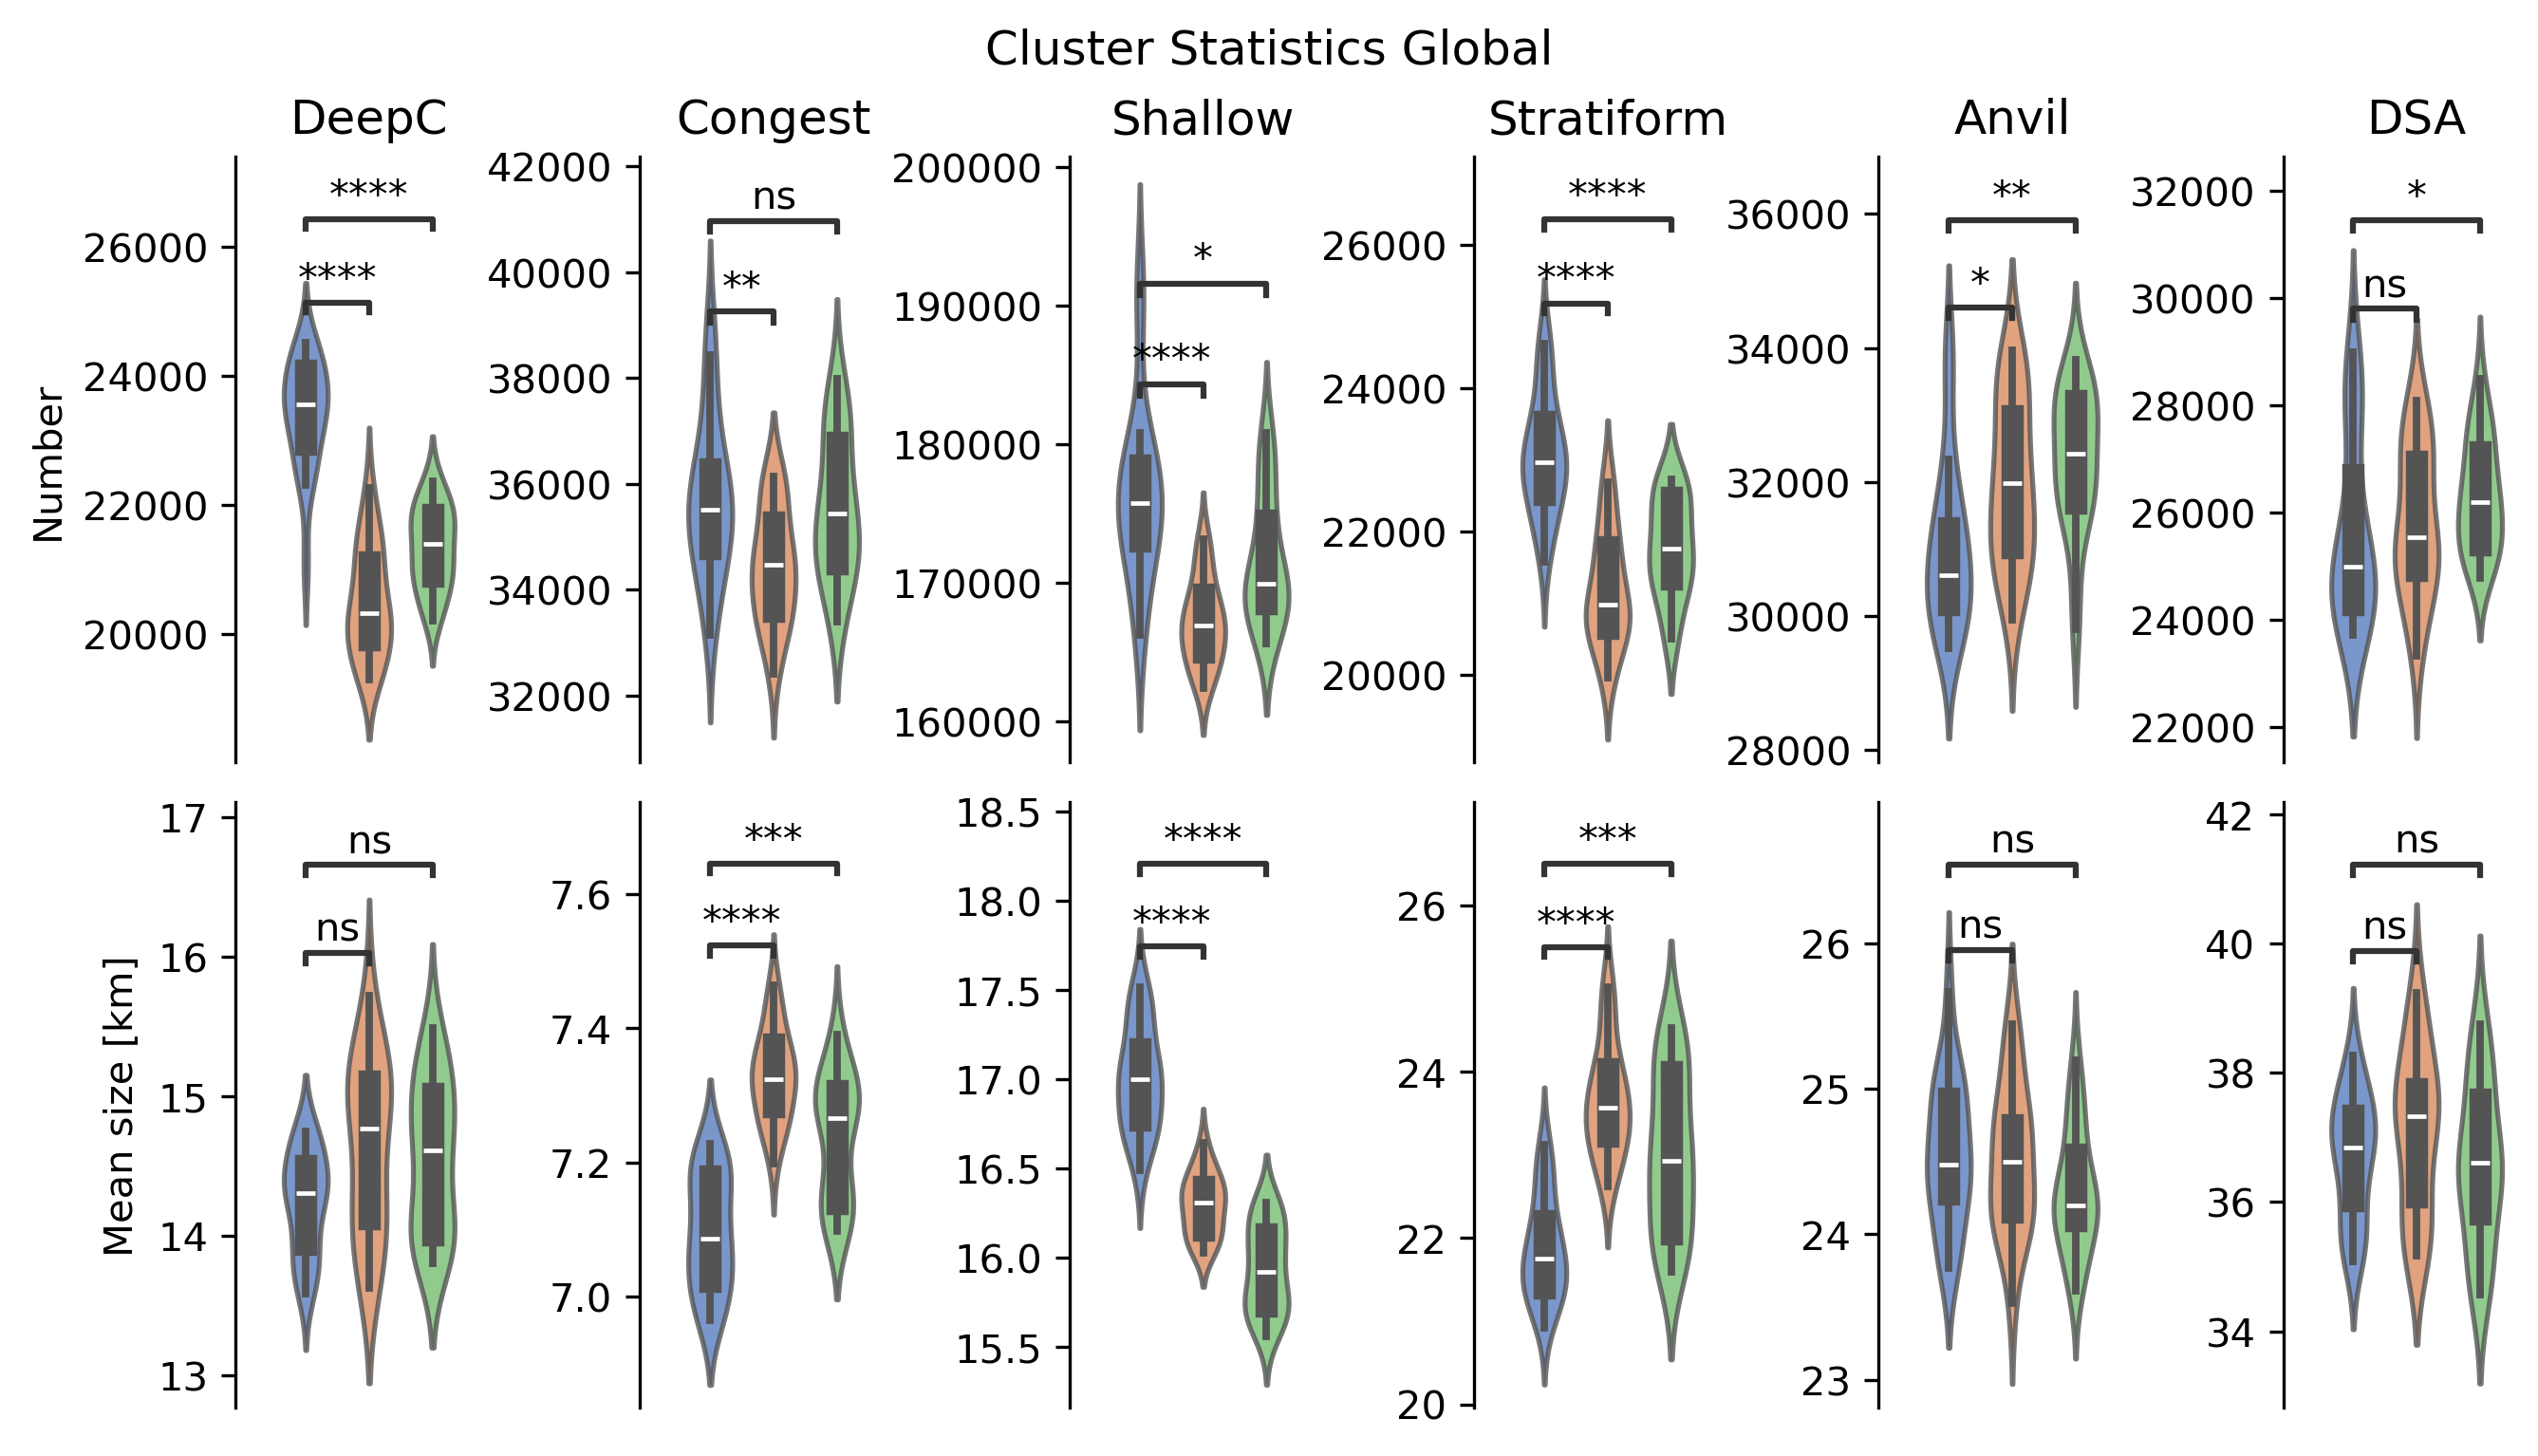

In [18]:
def plot_boxplots(pltvar, axs, do_legend=False):
      colors = sns.color_palette('muted', n_colors=ntest)
      for iclass, iax in enumerate(axs):
            # sns.boxplot([pltvar[iexp,:,iclass] for iexp in range(pltvar.shape[0])],
            #             width=0.7, showmeans=True,
            #             meanprops={"marker":"o", "markerfacecolor":"white",
            #                   "markeredgecolor":"black", "markersize":"6"},
            #             palette=colors,
            #             ax=iax, notch=True, showcaps=False, bootstrap=10000,
            #             showfliers=True,)
            sns.violinplot([pltvar[iexp,:,iclass] for iexp in range(pltvar.shape[0])],
                           width=0.7,
                           palette=colors, alpha=0.8,
                           inner="box", #split=True,
                           gap=0.01,
                           ax=iax)
            sns.despine(ax=iax, bottom=True)

            # Add t-test
            # t_stat, p_value = ttest_ind(pltvar[0,:,iclass],
            #                         pltvar[1,:,iclass],
            #                         equal_var=True)
            # iax.text(0.5, -0.11, str(np.round(p_value, 3)),
            #          ha='center', va='top', transform=iax.transAxes)#, fontsize=10)

            # Annotate with significance
            pairs = [(0, 1), (0, 2)]
            annotator = Annotator(iax, pairs, data=[pltvar[iexp,:,iclass] for iexp in range(pltvar.shape[0])])
            annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
            annotator.apply_and_annotate()

      # if do_legend:
      #       axs[-1].legend(loc="upper right", frameon=False, fontsize=12, labels=test_names, bbox_to_anchor=(1.15, 0.5))
      #       handles = [plt.Line2D([0], [0], color=colors[i], lw=10) for i in range(ntest)]
      #       axs[-1].legend(handles=handles, labels=test_names, loc="center right", frameon=False,
      #                      fontsize=12, bbox_to_anchor=(5.0, 0.5))
      return axs

nsubset, subset_tags, latbounds, global_subset = subset_settings()

itimes = range(20,ntime) # last 5 days
# itimes = range(ntime)

for isubset in range(nsubset):

      # Get latitude bounds
      nsubset, subset_tags, latbounds, global_subset = subset_settings(isubset)

      # create figure
      fig_x = 1.3*nclass + 1
      fig_y = 5
      fig, axs = plt.subplots(2,nclass, figsize=(fig_x,fig_y), layout="constrained", dpi=300)

      title = f"Cluster Statistics {subset_tags[isubset]}"
      fig.suptitle(title)

      # Cluster counts
      pltvar = numbers[isubset,:,itimes,:].transpose(1,0,2)
      ytitle = 'Number'
      irow = 0
      axs[irow, 0].set_ylabel(ytitle)
      # plot_boxplots(pltvar, axs.flatten()[0:nclass], ntest, it_max, ytitle, do_legend=True)
      axs[irow,:] = plot_boxplots(pltvar[:,:,:], axs[irow,:])

      # Cluster sizes
      pltvar = mean_sizes[isubset,:,itimes,:].transpose(1,0,2)
      ytitle = 'Mean size [km]'
      # plot_boxplots(pltvar, axs.flatten()[nclass:nclass*2], ntest, it_max, ytitle, do_legend=True)
      irow = 1
      axs[irow, 0].set_ylabel(ytitle)
      axs[irow,:] = plot_boxplots(pltvar[:,:,:], axs[irow,:])

      for iclass in range(nclass):
            axs[0,iclass].set_title(pclass_names_long[iclass])

      for iaxs in axs.flatten():
            sns.despine(offset=10,ax=iaxs, top=True, right=True, bottom=True)
            iaxs.set_xticks([])

      # axs[1,nclass-1].legend(loc="upper right", labels=test_names,
      #                        frameon=False, fontsize=12, bbox_to_anchor=(1.15, 0.5))

      plt.show()
      plt.close()

#### Time series

In [29]:
def do_tser(figdata, do_legend=False):
    ntest = figdata['number'].shape[0]
    sns.set_palette('muted')
    smooth=True
    # smooth=False
    pclass_plot = [0,3,4,5]
    # pclass_plot = [0,1,2,3,4,5]
    npclass_plot = len(pclass_plot)
    fig_x, fig_y = 10, 12
    fig, ax = plt.subplots(npclass_plot,2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True, dpi=75)
    ax[npclass_plot-1,0].set_xlabel('Day')
    ax[npclass_plot-1,1].set_xlabel('Day')
    fig.suptitle(figdata['suptitle'])
    xdim = np.arange(ntime)/4
    for ipclass in range(npclass_plot):
        for icol in range(2):
            if icol == 0:
                pltvar = figdata['number']
                ax[0,icol].set_title('Number')
                ax[ipclass,icol].set_ylabel(figdata['units'][pclass_plot[ipclass]])
            else:
                pltvar = figdata['size']
                # ax[0,icol].set_title('Mean Diamater [km]')
                ax[0,icol].set_title('Mean size [km]')
            # Plot zero line
            # ax[ipclass,icol].axhline(0, color='black', linewidth=1)
            pltvar = pltvar[:,:,pclass_plot[ipclass]]
            # ax[ipclass,icol].set_xlim([0,t_max])
            for itest in range(ntest):
                pvar = pltvar[itest]
                # pvar_smooth, confidence_interval, nwindow = running_mean_conf(pvar)
                # x_smoothed = times_3d[nwindow//2:-nwindow//2+1]
                # ax[ipclass,icol].plot(file_times, pvar_smooth, label=figdata['tests_str'][itest], linewidth=1.8)
                ax[ipclass,icol].plot(xdim, pvar, label=figdata['tests_str'][itest], linewidth=1.8)
                # ax[ipclass,icol].fill_between(x_smoothed, pvar_smooth - confidence_interval,
                #                     pvar_smooth + confidence_interval,
                #                     alpha=0.4, label="95% CI", zorder=0)
                # mean, low, high = mean_confidence_interval(pvar)
                # ax[ipclass,icol].plot(pvar, linestyle=linestyle[itest], color=linecolor[itest], label=figdata['tests_str'][itest])
                # var_smooth = pd.DataFrame(mean)
                # var_smooth = var_smooth.rolling(window=3, center=True, closed='both').mean()
                # ax[iprof].plot(var_smooth, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
                # if (itest == 0) or (itest == 2):
                # if (itest == 1) or (itest == 2):
                # xdim = range(0,mean.shape)
                # ax[ipclass,icol].fill_between(xdim, high, low, alpha=0.1, color=linecolor[itest])
            if do_legend & (ipclass == 0) & (icol == 0):
                ax[ipclass,icol].legend(loc='lower right', frameon=False)#, 
                                        # bbox_to_anchor=(0.1, 0.85))
            sns.despine(offset=10, ax=ax[ipclass,icol])
    plt.show()
    plt.close()

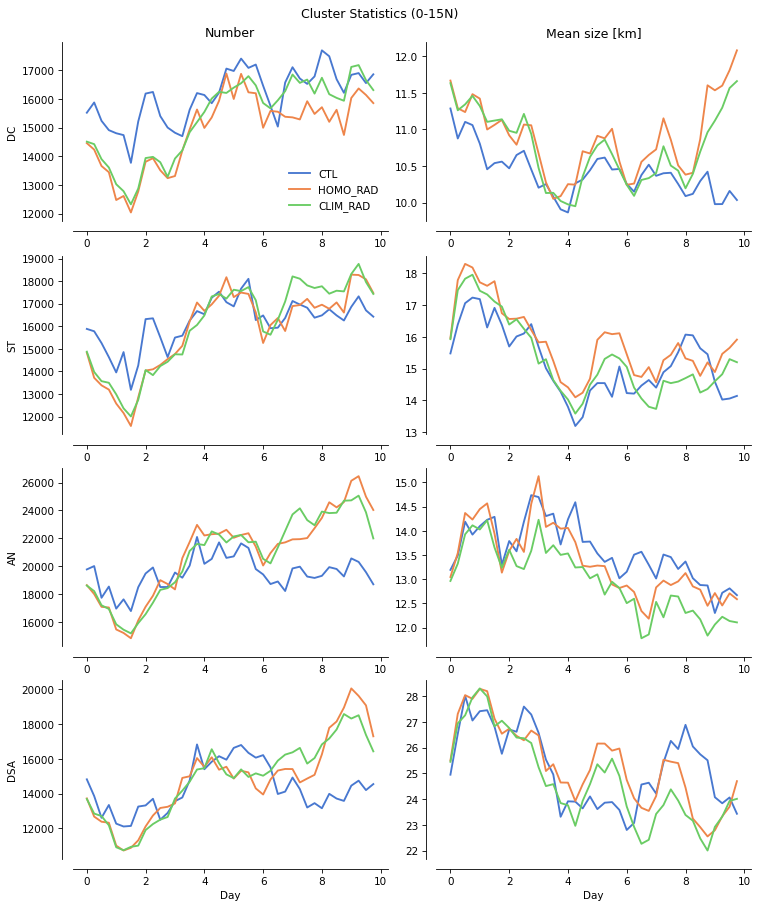

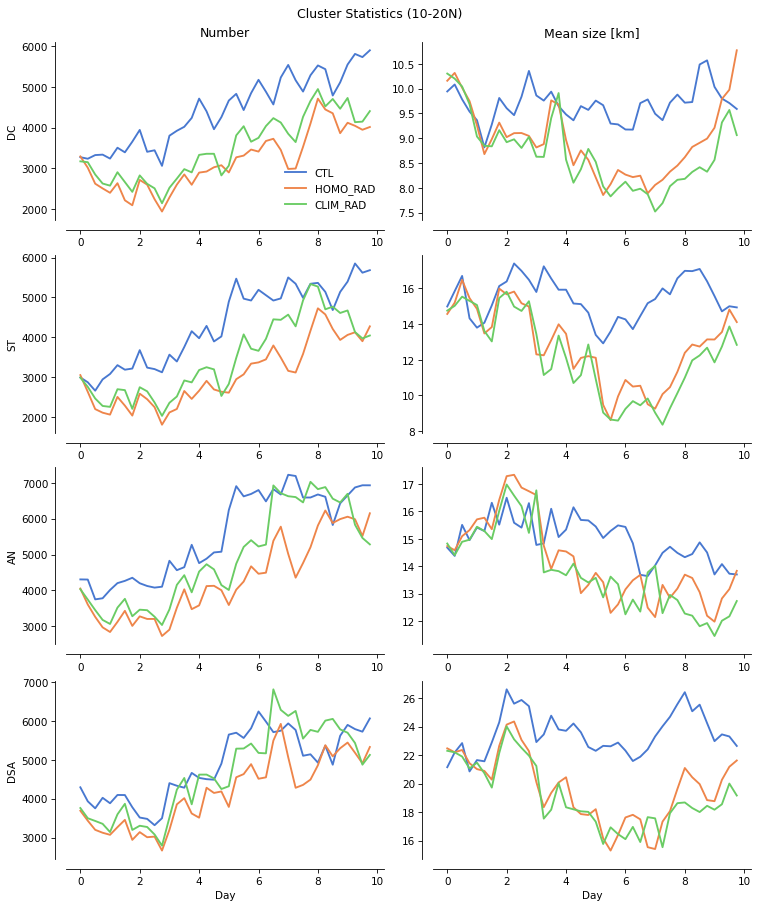

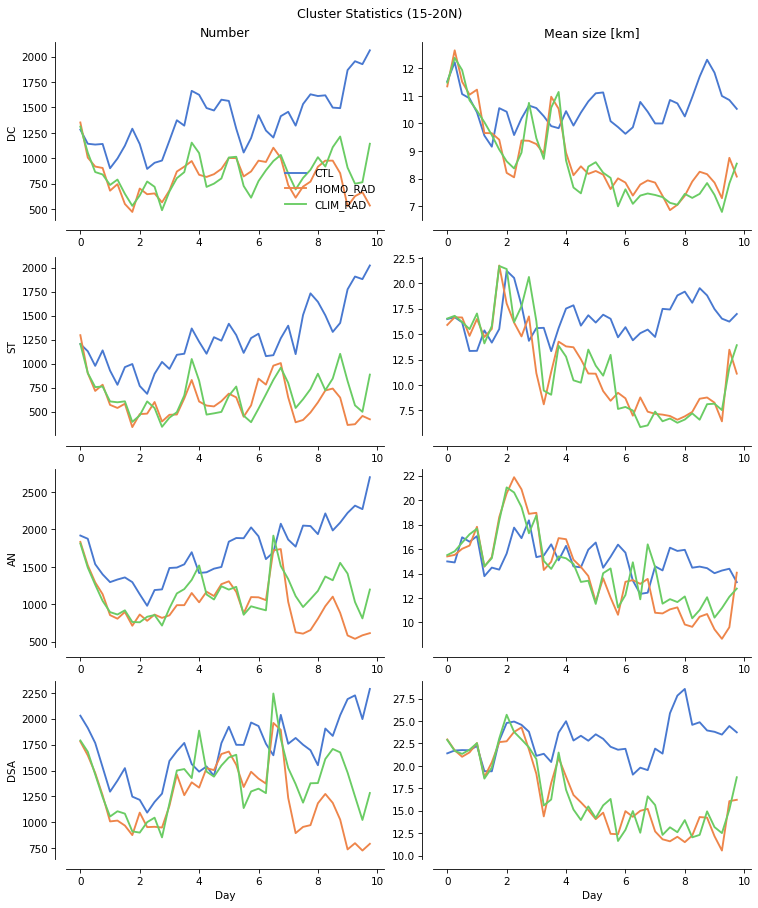

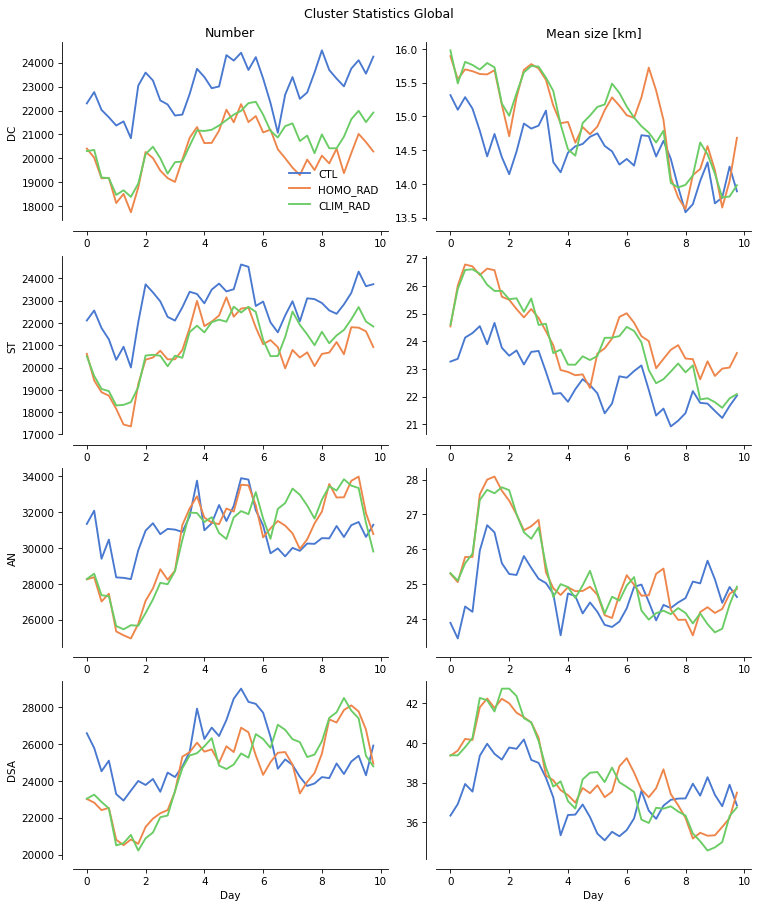

In [30]:
for isubset in range(nsubset):
# for isubset in range(1):

    # Difference from CTL
    # number_ctlanom = ctldiff(number)
    # # radius_ctlanom = ctldiff(radius)
    # # mean_size_ctlanom = ctldiff(mean_size)
    # mean_size_ctlanom = ctldiff(mean_sizes)

    figdata = {
        # 'size': diam, # dims = (ntest, nmem, npclass, nt)
        # 'size': mean_size, # dims = (ntest, nmem, npclass, nt)
        # 'number': number, # dims = (ntest, nmem, npclass, nt)
        'size': mean_sizes[isubset], # dims = (ntest, nmem, npclass, nt)
        'number': numbers[isubset], # dims = (ntest, nmem, npclass, nt)
        'tests_str': exp_names,
        'units': pclass_names,
        'suptitle': f"Cluster Statistics {subset_tags[isubset]}",
        }

    do_legend=True
    # if kpclass == npclass-1:
    #     do_legend=True

    do_tser(figdata, do_legend=do_legend)